# Creating Dataset

In [2]:
base_dir = 'Dataset/UTKFace/'

In [4]:
from tqdm import tqdm
import os

image_files = []
age_categories = []
gender_categories = []


for file in tqdm(os.listdir(base_dir)):
    file_path = os.path.join(base_dir, file)
    file_parts = file.split('_')
    age_value = int(file_parts[0])
    gender_value = int(file_parts[1])

    image_files.append(file_path)
    age_categories.append(age_value)
    gender_categories.append(gender_value)


100%|█████████████████████████████████| 23708/23708 [00:00<00:00, 668036.43it/s]


In [5]:
import pandas as pd

In [6]:
df = pd.DataFrame({
    'image': image_files,
    'age': age_categories,
    'gender': gender_categories
})

df.head()

,image,age,gender
0,Dataset/UTKFace/9_1_2_20161219204347420.jpg.ch...,9,1
1,Dataset/UTKFace/36_0_1_20170117163203851.jpg.c...,36,0
2,Dataset/UTKFace/86_1_0_20170120225751953.jpg.c...,86,1
3,Dataset/UTKFace/26_1_0_20170116171048641.jpg.c...,26,1
4,Dataset/UTKFace/1_1_2_20161219154612988.jpg.ch...,1,1


In [7]:
gender_dictionary = {0: 'Male', 1: 'Female'}

# EDA

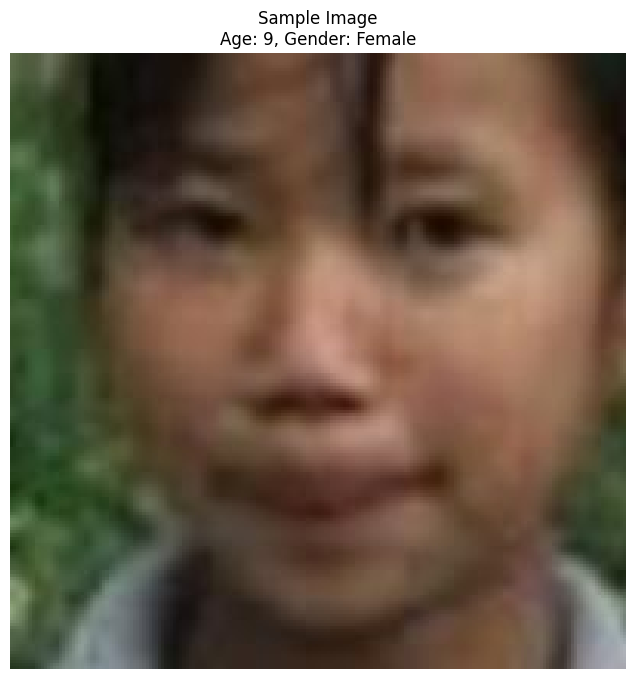

In [9]:
from PIL import Image
import matplotlib.pyplot as plt


img_path = df['image'][0]
img = Image.open(img_path)


plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.title(f"Sample Image\nAge: {df['age'][0]}, Gender: {gender_dictionary[df['gender'][0]]}")
plt.axis('off')
plt.show()

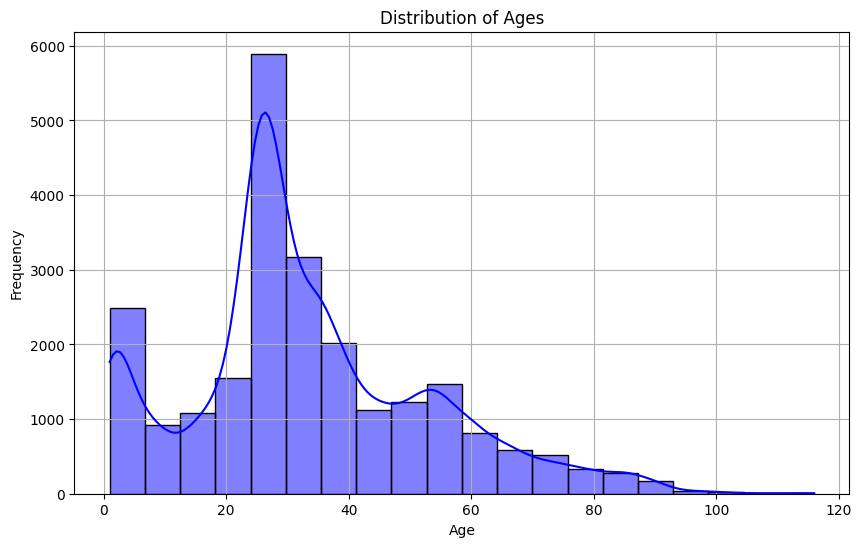

In [10]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=20, kde=True, color='blue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Ages')
plt.grid(True)
plt.show()

/var/folders/l0/1187xf1x5bz0ltr7dq12m2f40000gn/T/ipykernel_39471/3326338165.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='gender', data=df, palette='Set2')
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_grou

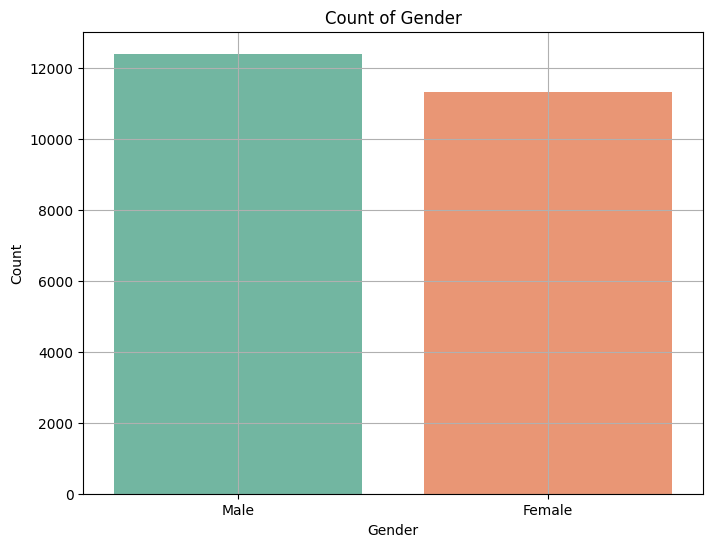

In [11]:
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', data=df, palette='Set2')
plt.xticks(ticks=[0, 1], labels=['Male', 'Female'])
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Count of Gender')
plt.grid(True)
plt.show()

In [41]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

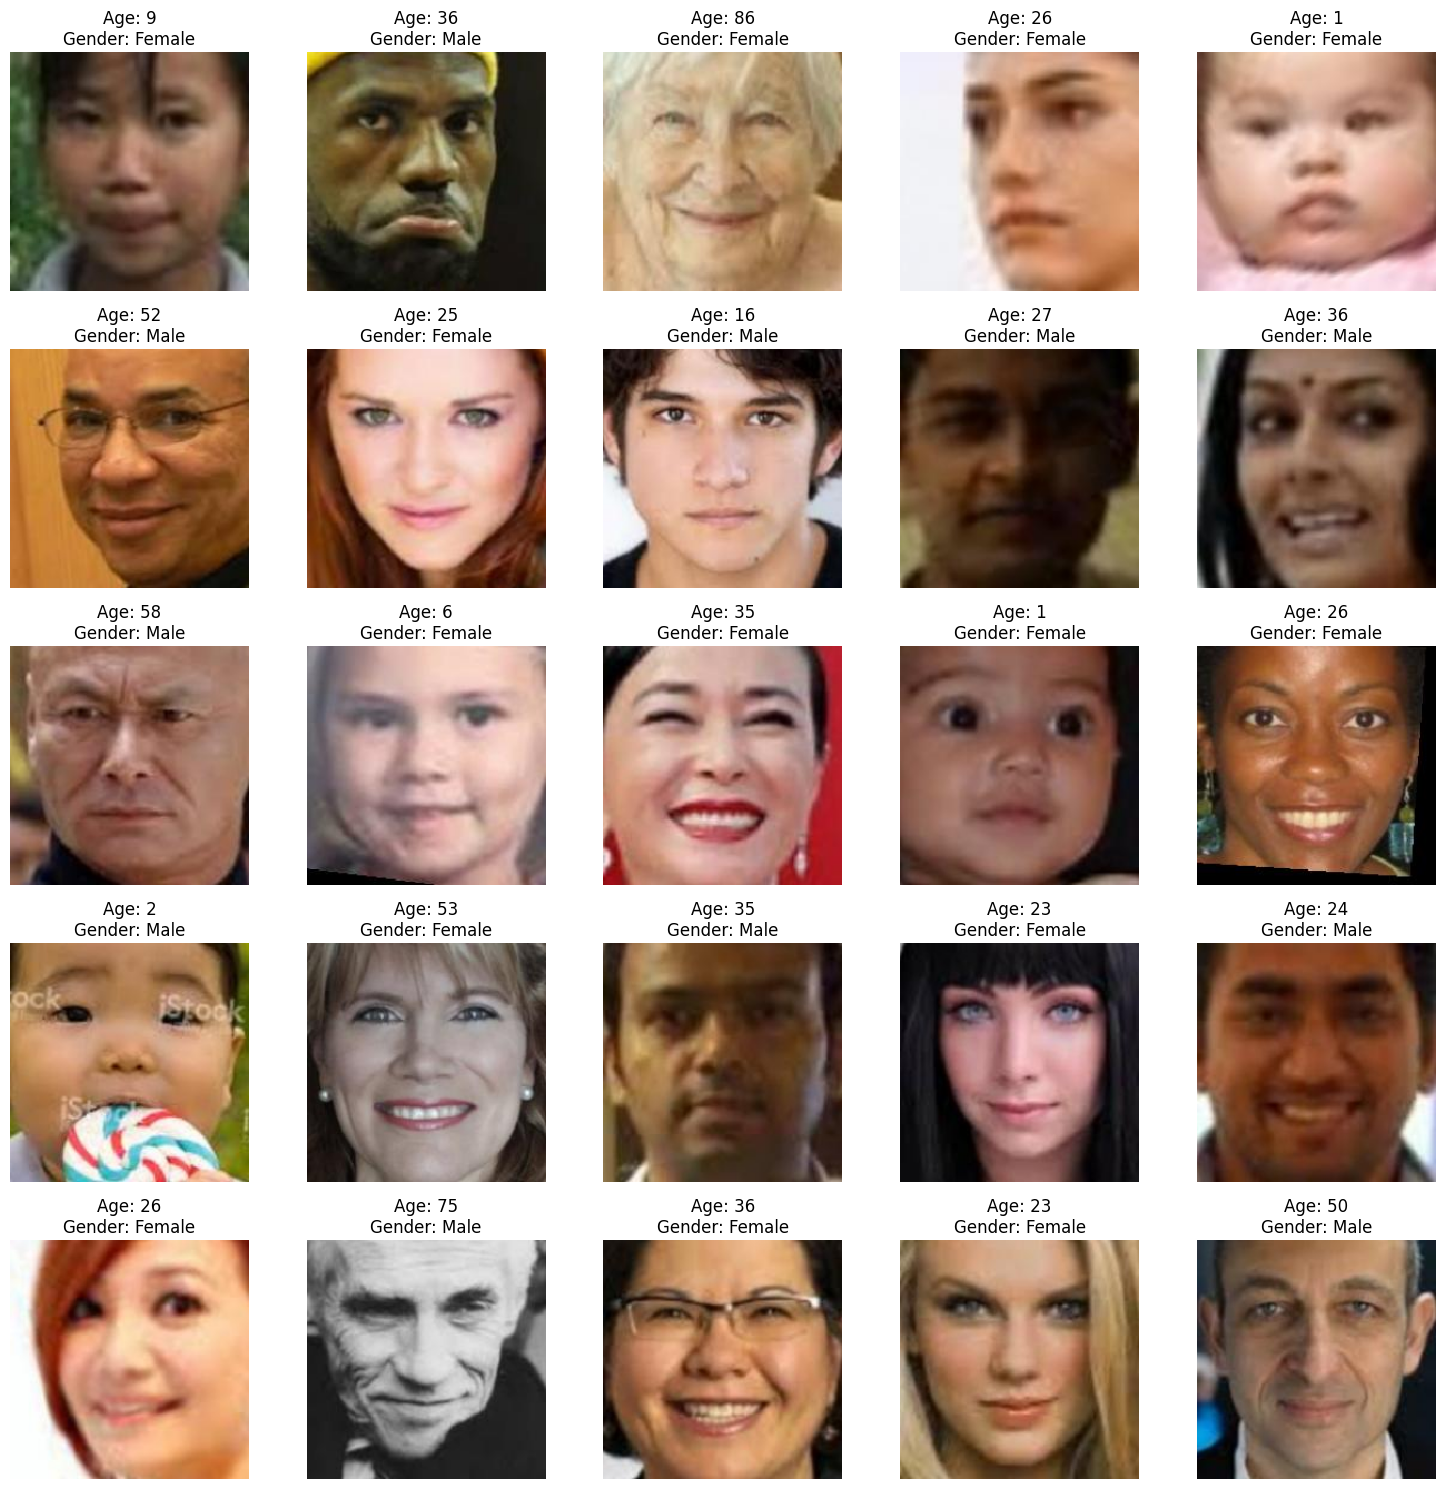

In [42]:
plt.figure(figsize=(15, 15))

files = df.iloc[0:25]

for index, (file, age, gender) in enumerate(zip(files['image'], files['age'], files['gender'])):
    plt.subplot(5, 5, index + 1)
    img = load_img(file, target_size=(224, 224))
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age}\nGender: {gender_dictionary[gender]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Feature Extraction

In [46]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = Image.open(image).convert('L')
        img = img.resize((128, 128), Image.LANCZOS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)

    features = features.reshape(len(features), 128, 128, 1)
    return features

In [47]:
X = extract_features(df['image'])

100%|████████████████████████████████████| 23708/23708 [00:33<00:00, 698.02it/s]


In [48]:
X.shape

(23708, 128, 128, 1)

In [51]:
X=X/255.0

In [52]:
y_gender = np.array(df['gender'])

y_age = np.array(df['age'])

In [56]:
y_age

array([ 9, 36, 86, ..., 26, 28, 50])

# Model Creation

In [79]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

input_shape = (128, 128, 1)
inputs = Input(shape=input_shape)

conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
maxpool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(maxpool1)
maxpool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(maxpool2)
maxpool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(maxpool3)
maxpool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

flatten = Flatten()(maxpool4)

dense1 = Dense(256, activation='relu')(flatten)
dense2 = Dense(256, activation='relu')(flatten)

dropout1 = Dropout(0.4)(dense1)
dropout2 = Dropout(0.4)(dense2)

output_gender = Dense(1, activation='sigmoid', name='gender_output')(dropout1)
output_age = Dense(1, activation='relu', name='age_output')(dropout2)

model = Model(inputs=inputs, outputs=[output_gender, output_age])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

In [80]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 126, 126,  │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 63, 63,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 30, 30,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 28, 28,    │     73,856 │ max_pooling2d_9[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 14, 14,    │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 12, 12,    │    295,168 │ max_pooling2d_10… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 6, 6, 256) │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 9216)      │          0 │ max_pooling2d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │  2,359,552 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │  2,359,552 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 1)         │        257 │ dropout_4[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_output (Dense)  │ (None, 1)         │        257 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,107,458 (19.48 MB)

 Trainable params: 5,107,458 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

In [81]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_gender_output_accuracy', mode='max', patience=4, restore_best_weights=True)

history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 332s 555ms/step - age_output_mae: 16.8047 - gender_output_accuracy: 0.5200 - loss: 17.5227 - val_age_output_mae: 12.5841 - val_gender_output_accuracy: 0.7278 - val_loss: 13.1402
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 270s 456ms/step - age_output_mae: 12.0541 - gender_output_accuracy: 0.7476 - loss: 12.5720 - val_age_output_mae: 10.8457 - val_gender_output_accuracy: 0.7906 - val_loss: 11.2894
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 263s 444ms/step - age_output_mae: 9.7997 - gender_output_accuracy: 0.8108 - loss: 10.2175 - val_age_output_mae: 8.3232 - val_gender_output_accuracy: 0.8229 - val_loss: 8.7067
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 262s 442ms/step - age_output_mae: 8.6804 - gender_output_accuracy: 0.8365 - loss: 9.0383 - val_age_output_mae: 7.9276 - val_gender_output_accuracy: 0.8355 - val_loss: 8.2808
Epoch 5/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 268s 453ms/step - age_output_mae: 7.8105 - gender_output_accuracy: 0.8528 - loss: 8.1390 - val_

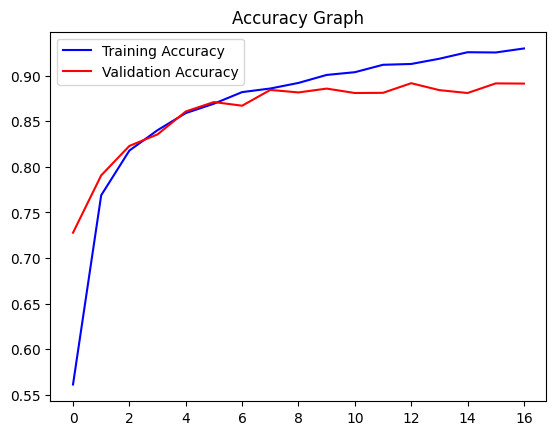

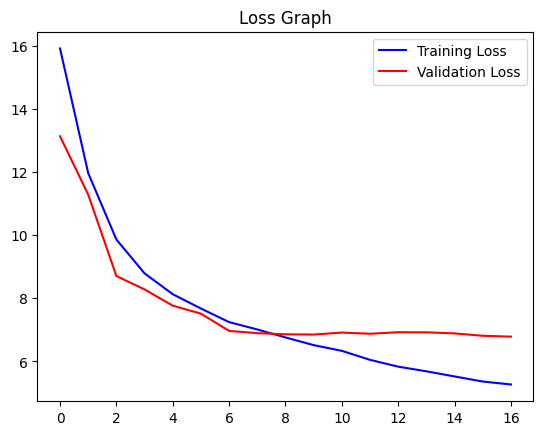

In [84]:
acc = history.history['gender_output_accuracy']
val_acc = history.history['val_gender_output_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

# Prediction with Test Data

In [114]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def display_prediction(model, X, y_gender, y_age, file_path, gender_dictionary):
    """
    Display the original and predicted gender and age of a specific image from the dataset.

    Args:
    model: Trained Keras model.
    X: Array of image data.
    y_gender: Array of gender labels.
    y_age: Array of age labels.
    image_index: Index of the image in the dataset to display.
    gender_dict: Dictionary mapping gender labels to their names.

    Returns:
    None
    """


    # Predict from model
    img = load_img(file_path, color_mode='grayscale', target_size=(128, 128))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    
    pred = model.predict(img_array)
    pred_gender = gender_dictionary[round(pred[0][0][0])]
    pred_age = round(pred[1][0][0])

    # Display predicted gender and age

    print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)

    # Display the image
    plt.axis('off')
    plt.imshow(img_array.reshape(128, 128), cmap='gray')
    plt.show()

# Example usage


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Gender: Male Predicted Age: 69


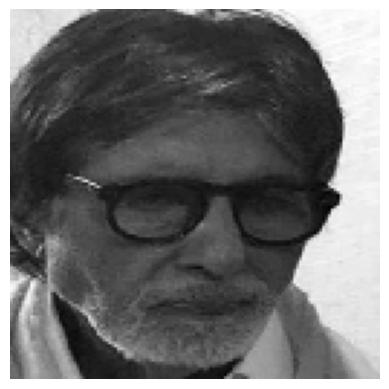

In [115]:
display_prediction(model, X, y_gender, y_age, 'amitabh.jpg', gender_dictionary)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Gender: Female Predicted Age: 29


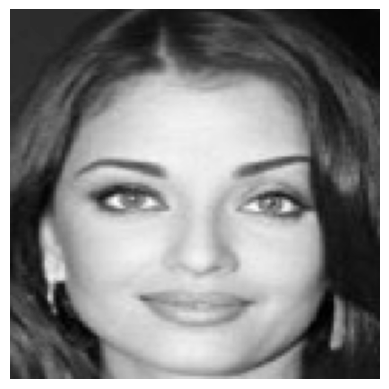

In [116]:
display_prediction(model, X, y_gender, y_age, 'aishwarya.jpg', gender_dictionary)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted Gender: Male Predicted Age: 40


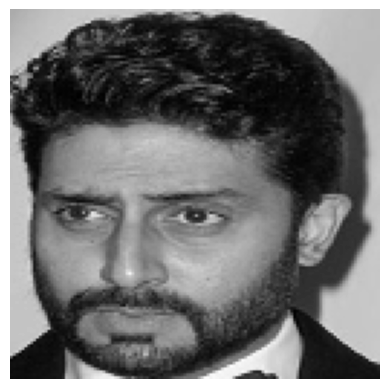

In [121]:
display_prediction(model, X, y_gender, y_age, 'abhishek.jpg', gender_dictionary)